In [1]:
import re, json, csv
import numpy as np
import sys, os
import pandas as pd
import googlemaps

import matplotlib as mplib
import matplotlib.pyplot as plt # visualization package
import seaborn as sns
import geopandas as gpd

In [2]:
from shapely.geometry import Point

In [3]:
% matplotlib inline

In [4]:
t = pd.read_csv('summary-table.txt',nrows=1)
#t.iloc[0]

In [4]:
eviction_file = 'summary-table.txt'
df_summary = pd.read_csv(eviction_file,usecols=['id','year','month','latitude','longitude','gender','census','a','b','c','a_only','b_only','c_only'])
df_summary.iloc[0]

id             LT-07-04-13-4943
year                       2007
month                         4
a                             f
b                             f
c                             f
a_only                        f
b_only                        f
c_only                        f
latitude                40.0057
longitude              -75.1851
gender                     male
census       14000US42101017000
Name: 0, dtype: object

In [5]:
df = df_summary.loc[df_summary['year'] > 2011].loc[df_summary['year'] < 2016]
df['geometry'] = [Point(x['longitude'],x['latitude']) for i,x in df.iterrows()]
gdf = gpd.GeoDataFrame(df)

In [6]:
gdf = gdf.drop(gdf[['latitude','longitude']],axis=1)
gdf.head(2)

,id,year,month,a,b,c,a_only,b_only,c_only,gender,census,geometry
46,LT-14-04-14-4277,2014.0,4.0,f,f,t,f,f,t,female,14000US42101001800,POINT (-75.15936500000001 39.93972700000001)
50,LT-12-04-16-4455,2012.0,4.0,f,f,t,f,f,t,female,14000US42101003600,POINT (-75.191253 39.925259)


In [62]:
len(df.loc[df['latitude'].isnull()]) / float(len(df))

0.006656505645587732

# Locating in Council Districts

In [7]:
dists = gpd.read_file('../../geodata/council_districts/Council_Districts_2016.shp')
dists.head()

,OBJECTID,ID,DISTRICT,geometry
0,1,0,1,"POLYGON ((-75.0932948389698 39.9932300437038, ..."
1,2,0,2,"POLYGON ((-75.17407568314729 39.9493998139779,..."
2,3,0,3,"POLYGON ((-75.2206447317877 39.974366639923, -..."
3,4,0,4,"POLYGON ((-75.2305583949276 40.0827205113823, ..."
4,5,0,6,"POLYGON ((-75.0938330043444 39.9743827206332, ..."


In [8]:
gdf_dists = gpd.sjoin(gdf,dists,how='left',op='within')

In [9]:
gdf_dists = gdf_dists.drop(gdf_dists[['index_right','OBJECTID','ID']],axis=1)

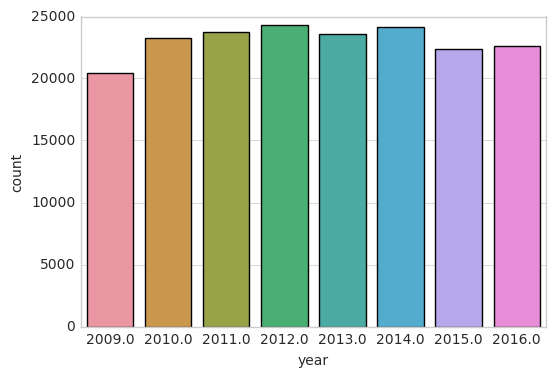

In [124]:
sns.countplot(x='year',data=df_summary.loc[df_summary['year']>2008].loc[df_summary['year']<2017])

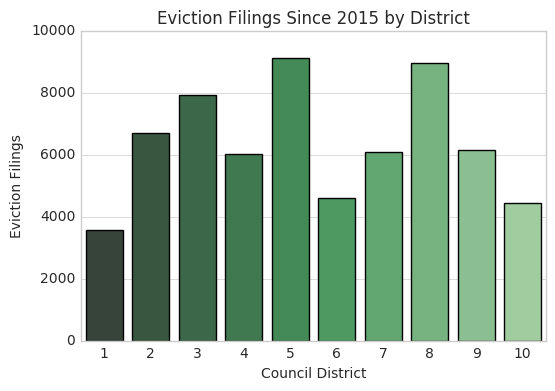

In [96]:
sns.set_style("whitegrid")
ax = sns.countplot(x='DISTRICT',data=gdf_dists, palette='Greens_d',order=[str(x) for x in (range(1,11))])
ax.set(xlabel='Council District', ylabel='Eviction Filings',title='Eviction Filings Since 2015 by District')

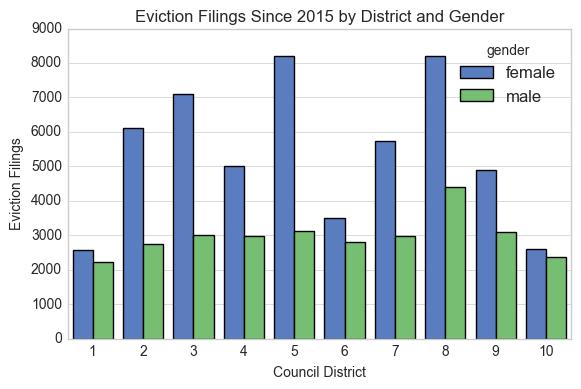

In [62]:
sns.set_style("whitegrid")
plt.figure(figsize=(6.5,4))
ax = sns.countplot(x='DISTRICT',hue='gender',data=gdf_dists,
                   palette="muted",order=[str(x) for x in (range(1,11))])
ax.set(xlabel='Council District', ylabel='Eviction Filings',title='Eviction Filings Since 2015 by District and Gender')

In [52]:
dist = gdf_dists.loc[gdf_dists['']]
f = len(df.loc[df['gender'] == 'female'])
m = len(df.loc[df['gender'] == 'male'])
print "female:" + str(f)
print "male:" + str(m)
print "ratio: " + str(float(f)/m) + " : 1"

female:36556
male:20185
ratio: 1.81104780778 : 1


In [63]:
annual = pd.DataFrame(df_summary['year'].value_counts(sort=False))
annual = annual.loc[annual.index > 2003]

In [64]:
annual['count'] = annual['year']
annual['year']=annual.index
annual = annual.loc[annual['year'] < 2017]

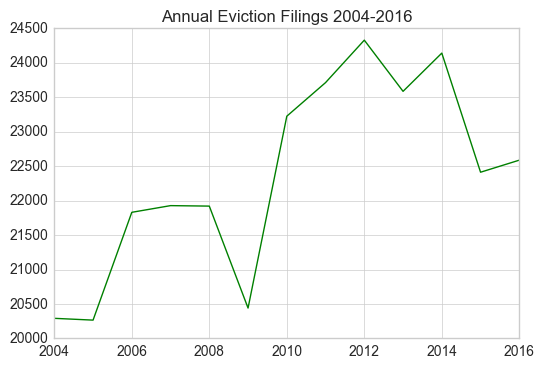

In [69]:
annual.plot(y='count',color='green',legend=False,title='Annual Eviction Filings 2004-2016')

In [73]:
annual['nocause'] = df_summary.loc[df_summary['b_only'] == 't']['year'].value_counts(sort=False)

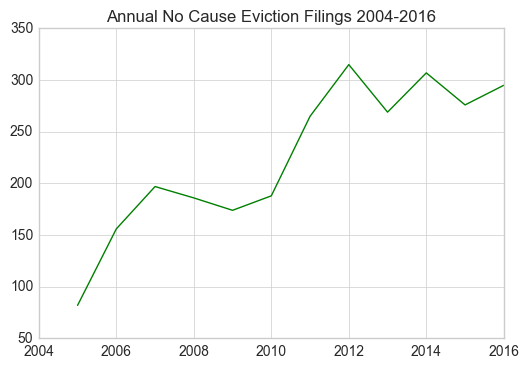

In [76]:
annual.plot(y='nocause',color='green',legend=False,title='Annual No Cause Eviction Filings 2004-2016')

# Locating in Census Tracts....

In [10]:
tracts = gpd.read_file('../../geodata/tracts/Census_Tracts_2010.shp')
tracts.head(2)

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,geometry
0,1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429,"POLYGON ((-75.22926522780659 39.9605446656843,..."
1,2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430,"POLYGON ((-75.2353591940378 39.9685190282368, ..."


In [35]:
gdf['GEOID10'] = gdf['census'].str[7:]

# Race Data...

In [74]:
race = pd.read_csv('../../tract_level/race_ACS_15_5YR_B02001_with_ann.csv',skiprows=[1])
race.head(2)

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,...,HD01_VD06,HD02_VD06,HD01_VD07,HD02_VD07,HD01_VD08,HD02_VD08,HD01_VD09,HD02_VD09,HD01_VD10,HD02_VD10
0,1400000US42101000100,42101000100,"Census Tract 1, Philadelphia County, Pennsylvania",3608,389,2807,356,361,116,6,...,0,10,27,43,90,53,20,31,70,58
1,1400000US42101000200,42101000200,"Census Tract 2, Philadelphia County, Pennsylvania",2331,381,911,225,141,82,11,...,0,10,21,33,64,55,11,16,53,54


In [35]:
reference_col_race = pd.read_csv('../../tract_level/race_ACS_15_5YR_B02001_with_ann.csv',nrows=2)
reference_col_race.head(2)

,GEO.id,GEO.id2,GEO.display-label,HD01_VD01,HD02_VD01,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,...,HD01_VD06,HD02_VD06,HD01_VD07,HD02_VD07,HD01_VD08,HD02_VD08,HD01_VD09,HD02_VD09,HD01_VD10,HD02_VD10
0,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Total: - White alone,Margin of Error; Total: - White alone,Estimate; Total: - Black or African American a...,Margin of Error; Total: - Black or African Ame...,Estimate; Total: - American Indian and Alaska ...,...,Estimate; Total: - Native Hawaiian and Other P...,Margin of Error; Total: - Native Hawaiian and ...,Estimate; Total: - Some other race alone,Margin of Error; Total: - Some other race alone,Estimate; Total: - Two or more races:,Margin of Error; Total: - Two or more races:,Estimate; Total: - Two or more races: - Two ra...,Margin of Error; Total: - Two or more races: -...,Estimate; Total: - Two or more races: - Two ra...,Margin of Error; Total: - Two or more races: -...
1,1400000US42101000100,42101000100,"Census Tract 1, Philadelphia County, Pennsylvania",3608,389,2807,356,361,116,6,...,0,10,27,43,90,53,20,31,70,58


In [33]:
#predominately black tracts, %25.5 of total
black = race.loc[pd.to_numeric(race['HD01_VD03']).astype(float) / pd.to_numeric(race['HD01_VD01']) * 100 > 80]

0.2552083333333333

In [38]:
gdf_dists = gpd.sjoin(gdf,dists,how='left',op='within')

In [80]:
council_district = 3
dist = gdf_dists.loc[gdf_dists['DISTRICT'] == str(council_district)]

In [75]:
def topRace(row):
    #white,black,amerindian,asiam,hawaiian
    return {
        'HD01_VD02':'White',
        'HD01_VD03':'Black',
        'HD01_VD04':'American Indian and Alaska Native',
        'HD01_VD05':'Asian',
        'HD01_VD06':'Native Hawaiian and Pacific Islander'
    }[row]

In [76]:
race['max_race_code'] = race[['HD01_VD02','HD01_VD03','HD01_VD04','HD01_VD05','HD01_VD06']].idxmax(axis=1)
race['max_race'] = race['max_race_code'].apply(topRace)
race['max_race'].value_counts()

White    203
Black    179
Asian      2
Name: max_race, dtype: int64

In [77]:
race['GEOID10'] = race['GEO.id2'].astype(str)

In [78]:
dist = pd.merge(gdf_dists[['id','GEOID10','year','DISTRICT']],race[['GEOID10','max_race']],on='GEOID10',how='left')

In [79]:
dist['Race'] = dist['max_race']

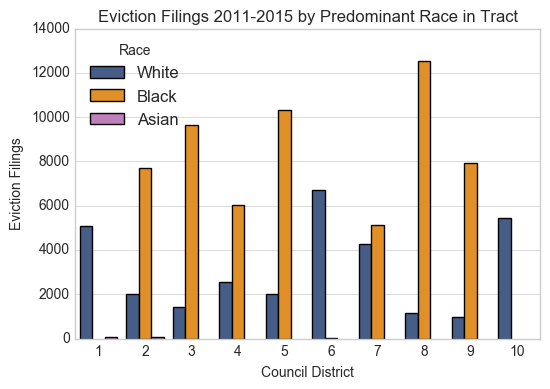

In [91]:
sns.set_style("whitegrid")
#plt.figure(figsize=(6.5,4))
flatui = [sns.xkcd_rgb["denim blue"],sns.xkcd_rgb["tangerine"],sns.xkcd_rgb["orchid"]]
ax = sns.countplot(x='DISTRICT',hue='Race',data=dist,
                   palette=flatui,order=[str(x) for x in (range(1,11))])
ax.set(xlabel='Council District', ylabel='Eviction Filings',title='Eviction Filings 2011-2015 by Predominant Race in Tract')

# Income...

In [55]:
def classifyPoverty(pct):
    try:
        if float(pct) > 20:
            return '20% Poverty or more'
        else:
            return 'Less than 20% Poverty'
    except ValueError:
        return 'ND'

In [56]:
poverty = pd.read_csv('../../tract_level/ACS_15_5YR_S1701_with_ann.csv',skiprows=[1])
poverty['Poverty'] = poverty['HC03_EST_VC01'].apply(classifyPoverty)

In [54]:
len(poverty.loc[poverty['Poverty'] == '>10% Poverty'])

65

In [57]:
gdf_dists['GEOID10'] = gdf_dists['census'].str[7:]
poverty['GEOID10'] = poverty['GEO.id2'].astype(str)
dist = pd.merge(gdf_dists[['id','GEOID10','year','DISTRICT']],poverty[['GEOID10','Poverty']],on='GEOID10',how='left')

In [63]:
dist = dist.loc[dist['Poverty'] != 'ND']

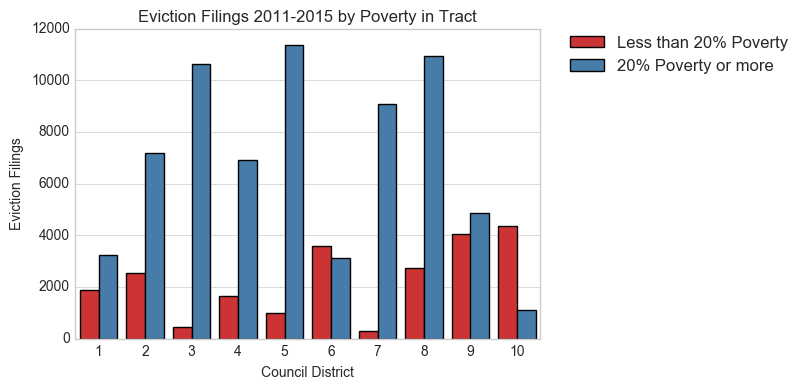

In [73]:
sns.set_style("whitegrid")
#plt.figure(figsize=(9,4))
ax = sns.countplot(x='DISTRICT',hue='Poverty',data=dist,
                   palette='Set1',order=[str(x) for x in (range(1,11))])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlabel='Council District', ylabel='Eviction Filings',title='Eviction Filings 2011-2015 by Poverty in Tract')

# September Stuff.....

In [45]:
address_file = 'tenant-addresses-cleaned.csv'
df = pd.read_csv(address_file,usecols=[0,1,2,3,5,6,7,8,9])

In [87]:
full_df['lat'][2],full_df['lon'][2]

(40.047536000000001, -75.151096999999993)

In [86]:
gmaps.reverse_geocode((full_df['lat'][2],full_df['lon'][2]),result_type='neighborhood')
#df['value'] = df.apply(lambda x: lookup(x['group'], x['name']), axis=1)

[{u'address_components': [{u'long_name': u'Belfield',
    u'short_name': u'Belfield',
    u'types': [u'neighborhood', u'political']},
   {u'long_name': u'Morton',
    u'short_name': u'Morton',
    u'types': [u'political', u'sublocality', u'sublocality_level_1']},
   {u'long_name': u'Philadelphia',
    u'short_name': u'Philadelphia',
    u'types': [u'locality', u'political']},
   {u'long_name': u'Philadelphia County',
    u'short_name': u'Philadelphia County',
    u'types': [u'administrative_area_level_2', u'political']},
   {u'long_name': u'Pennsylvania',
    u'short_name': u'PA',
    u'types': [u'administrative_area_level_1', u'political']},
   {u'long_name': u'United States',
    u'short_name': u'US',
    u'types': [u'country', u'political']}],
  u'formatted_address': u'Belfield, Philadelphia, PA, USA',
  u'geometry': {u'bounds': {u'northeast': {u'lat': 40.0490534,
     u'lng': -75.1496172},
    u'southwest': {u'lat': 40.0390165, u'lng': -75.15850060000001}},
   u'location': {u'lat':

In [51]:
len(df_summary)

668384

In [54]:
#merging table with coordinates with full case summary table, saving to file
full_df = pd.merge(df,df_summary,how='left',on='id')
full_df.to_csv('merged.csv')

In [94]:
#experiment on year: only 7 records without it (and consequently the 'month' field, too); best timestamp
times = full_df[['year','dates_heard','first_date_heard','hearing_date_and_time']]
print len(full_df[['year','dates_heard','first_date_heard','hearing_date_and_time']])

In [57]:
#experiment on records missing in table with coordinates: ~4,000 records total, and 134 records missing since 2014
no_id = df_summary[~df_summary.id.isin(df.id)]
no_id.loc[no_id['year'] > 2014] 

In [99]:
relevant = full_df.loc[full_df['year'] > 1989] #maaybe we'll use the 1990 census
print len(relevant)
relevant.to_csv('merged_1990.csv')

495953


In [101]:
import geopandas as gpd

In [106]:
full_df['geometry'] = full_df.apply(lambda z: Point(z.lat, z.lon), axis=1)
geo_full_df = gpd.GeoDataFrame(full_df)

In [118]:
shp = gpd.GeoDataFrame.from_file('Neighborhoods_Philadelphia.shp')

In [60]:
#FAIL
#result = geopandas.tools.sjoin(geo_full_df, shp, how="left")

# Print the results..
#result['NAME'].head(50)

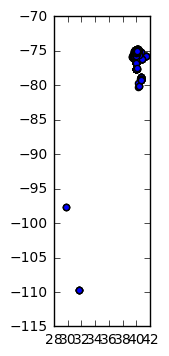

In [117]:
geo_full_df.plot()
plt.show()

<h2>START ANALYSIS OF MERGED TABLE</h2>

In [4]:
df = pd.read_csv('merged_1990.csv')

C:\Users\catst\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:
#Try to find apartments that Cross Properties is redeveloping at 1601-1603 Lombard St
df[df['plaintiff'].str.contains('CP AQUISITIONS',na=False)].sort_values('year',ascending=False)[['premises_x','defendant','plaintiff','month','year']]

,premises_x,defendant,plaintiff,month,year
204251,"707 CHESTNUT ST, PHILADELPHIA, PA",DEBORAH C. MAXWELL|AND|JOHN J. DESIMONE III|AN...,"CP AQUISITIONS 20, LP",5.0,2016.0
468476,"707 CHESTNUT ST, PHILADELPHIA, PA",DEBORAH C. MAXWELL|AND|JOHN J. DISIMONE III|AN...,"CP AQUISITIONS 20, LP",4.0,2016.0
534645,"707 CHESTNUT ST, PHILADELPHIA, PA",213T ASSOCIATES LLC|AND|BEATRIZ GARCES|AND|JOS...,"CP AQUISITIONS 20, LP",4.0,2016.0


In [4]:
#df[['a','b','c','a_only','b_only','c_only']].apply(for x indf[x].value_counts()

In [4]:
recent = df.loc[df['year'] > 2004].loc[df['year'] < 2017]

In [5]:
unjust_evictions = recent.loc[recent['b_only'] == 't'].groupby('year')['b_only'].value_counts()

In [6]:
total_yearly = recent.groupby('year')['id'].count()

In [7]:
total_yearly

year
2005.0    20200
2006.0    21761
2007.0    21852
2008.0    21869
2009.0    20402
2010.0    23196
2011.0    23628
2012.0    24238
2013.0    23502
2014.0    24070
2015.0    22349
2016.0    22530
Name: id, dtype: int64

In [44]:
perc_unjust = (unjust_evictions[year[0]]/float(total_yearly[year[0]]) for year in unjust_evictions.keys())
print perc_unjust

<generator object <genexpr> at 0x00000000360DCEA0>


In [11]:
#Experiment number something... breaking up eviction w/o just cause by zipcode!
recent = df.loc[df['year'] > 2012]
recent_unjust = recent.loc[recent['b_only'] == 't']
recent['zip'].value_counts().head(15)

19144    6622
19121    5096
19124    5043
19143    4632
19139    4536
19145    4230
19120    4144
19134    3872
19131    3752
19104    3685
19140    3460
19141    2975
19132    2946
19111    2937
19142    2656
Name: zip, dtype: int64

In [15]:
df['defendant'].head(30)

0     JACQUELYN COOPER & ALL OTHER OCCUPANTS|AND|JAM...
1      AMERICAN ABRASI VES INC|AND|HANS H VAN DER SANDE
2                                       SANTASIA THOMAS
3                                     WILLIAMS PATRICIA
4                                            KANE MOLLY
5                                          CROMER ALENE
6                                         JOHNSON ANN M
7                                        ROBINSON KEVIN
8     BRANDII SCOTT|AND|KAREESE NELSON & ALL OTHER O...
9                                          HOUGH SHEILA
10                                      DANIELLE GAINES
11                                    CRUTCHFELD TRACEY
12         DANTE CLARK|AND|MAUREEN HOOD & all occupants
13                       Katrina Neal and All Occupants
14                   ARTHUR MCDANIELS|AND|YVONNE BUTLER
15                                          NADIA BAKER
16                      BRUCE MURPHY|AND|KAYLA WILLIAMS
17                      JOHNSON SHAWN|AND|PERDOM

In [19]:
len(recent)

50437

# Searching out slumlords I: Lakewood Properties & Pelham Courts

In [52]:
df_summary.loc[df_summary['plaintiff_address'].str.contains("LAKEWOOD, NJ",na=False)].loc[
    df_summary['plaintiff'].str.contains('OLIVER',na=False)]['year'].value_counts()
#plt.show()

2009.0    28
2008.0    27
2010.0    22
2007.0    19
2012.0    18
2013.0    17
2011.0    15
2006.0    13
2015.0    10
2014.0     9
2005.0     5
Name: year, dtype: int64

In [64]:
df_summary.loc[df_summary['plaintiff'].str.contains('6100 MCCALLUM',na=False)]

,id,url,year,month,d_filing,a,b,c,a_only,b_only,...,zip,months,low_rent,publichousing,first_hearing_dow,latitude,longitude,clean_address,firstname,lastname
397701,LT-16-10-19-4958,https://fjdclaims.phila.gov/phmuni/casedocket/...,2016.0,10.0,2016-10-19 00:00:00,t,f,f,t,f,...,19144,NaN,NaN,f,2.0,NaN,NaN,NaN,NaN,NaN
397703,LT-16-10-17-4607,https://fjdclaims.phila.gov/phmuni/casedocket/...,2016.0,10.0,2016-10-17 00:00:00,t,f,f,t,f,...,19144,NaN,NaN,f,2.0,NaN,NaN,NaN,NaN,NaN
398797,LT-16-11-03-3321,https://fjdclaims.phila.gov/phmuni/casedocket/...,2016.0,11.0,2016-11-03 00:00:00,t,f,f,t,f,...,19144,NaN,NaN,f,1.0,NaN,NaN,NaN,NaN,NaN
398798,LT-16-11-03-3319,https://fjdclaims.phila.gov/phmuni/casedocket/...,2016.0,11.0,2016-11-03 00:00:00,t,f,f,t,f,...,19144,NaN,NaN,f,1.0,NaN,NaN,NaN,NaN,NaN
400649,LT-16-12-08-3888,https://fjdclaims.phila.gov/phmuni/casedocket/...,2016.0,12.0,2016-12-08 00:00:00,t,f,f,t,f,...,19144,NaN,NaN,f,5.0,NaN,NaN,NaN,NaN,NaN
402199,LT-17-01-06-3480,https://fjdclaims.phila.gov/phmuni/casedocket/...,2017.0,1.0,2017-01-06 00:00:00,t,f,f,t,f,...,19144,NaN,NaN,f,3.0,NaN,NaN,NaN,NaN,NaN
590009,LT-15-10-01-3105,https://fjdclaims.phila.gov/phmuni/casedocket/...,2015.0,10.0,2015-10-01 00:00:00,t,f,f,t,f,...,19144,1.215425,t,f,2.0,NaN,NaN,NaN,NaN,NaN
594564,LT-15-12-29-6011,https://fjdclaims.phila.gov/phmuni/casedocket/...,2015.0,12.0,2015-12-29 00:00:00,t,f,f,t,f,...,19144,2.784421,t,f,5.0,NaN,NaN,NaN,NaN,NaN
597867,LT-16-03-01-3133,https://fjdclaims.phila.gov/phmuni/casedocket/...,2016.0,3.0,2016-03-01 00:00:00,t,f,f,t,f,...,19144,1.843116,t,f,3.0,NaN,NaN,NaN,NaN,NaN
600665,LT-16-05-06-3624,https://fjdclaims.phila.gov/phmuni/casedocket/...,2016.0,5.0,2016-05-06 00:00:00,t,f,f,t,f,...,19144,1.669977,t,f,2.0,NaN,NaN,NaN,NaN,NaN


In [97]:
pelham = df_summary.loc[df_summary['plaintiff'].str.contains('PELHAM COURT',na=False)][['year','plaintiff_address']].sort_values(by='year')
#for i,row in pelham.iterrows():
    #print '%s\t%s' % (row['year'],row['plaintiff_address'])